In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


# Data Pre-Processing

In [2]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.stat import Correlation

In [3]:
#Creating a SparkSession
spark = SparkSession.builder \
    .appName("Big Data") \
    .getOrCreate()

In [4]:
df = spark.read.csv("data.csv", header=True, inferSchema=True)

In [5]:
#first few rows of the DataFrame
df.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [6]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [7]:
#Count occurrences of each value in the 'customerID' column
customerID_counts = df.groupBy("customerID").count().orderBy("count", ascending=False)
customerID_counts.show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows



In [8]:
#Drop the 'customerID' column
df = df.drop("customerID")

In [9]:
# Count occurrences of each value in the 'gender' column
gender_counts = df.groupBy("gender").count().orderBy("count", ascending=False)
gender_counts.show()

+------+-----+
|gender|count|
+------+-----+
|  Male| 3555|
|Female| 3488|
+------+-----+



In [10]:
# Count occurrences of each value in the 'SeniorCitizen' column
senior_citizen_counts = df.groupBy("SeniorCitizen").count().orderBy("count", ascending=False)
senior_citizen_counts.show()

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|            0| 5901|
|            1| 1142|
+-------------+-----+



In [11]:
# Count occurrences of each value in the 'Partner' column
partner_counts = df.groupBy("Partner").count().orderBy("count", ascending=False)
partner_counts.show()

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+



In [12]:
# Count occurrences of each value in the 'Dependents' column
dependents_counts = df.groupBy("Dependents").count().orderBy("count", ascending=False)
dependents_counts.show()

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+



In [13]:
# Count occurrences of each value in the 'tenure' column
tenure_counts = df.groupBy("tenure").count().orderBy("count", ascending=False)
tenure_counts.show()

+------+-----+
|tenure|count|
+------+-----+
|     1|  613|
|    72|  362|
|     2|  238|
|     3|  200|
|     4|  176|
|    71|  170|
|     5|  133|
|     7|  131|
|     8|  123|
|     9|  119|
|    70|  119|
|    12|  117|
|    10|  116|
|     6|  110|
|    13|  109|
|    68|  100|
|    15|   99|
|    11|   99|
|    67|   98|
|    18|   97|
+------+-----+
only showing top 20 rows



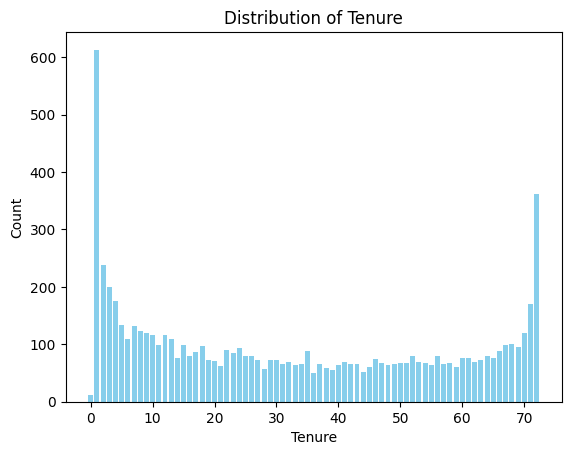

In [14]:
# Count occurrences of each value in the 'tenure' column
tenure_counts = df.groupBy("tenure").count().orderBy("tenure")
tenure_pd_df = tenure_counts.toPandas()

# Plotting the bar plot using matplotlib
plt.bar(tenure_pd_df['tenure'], tenure_pd_df['count'], width=0.8, color='skyblue')

# Adding labels and title
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.title('Distribution of Tenure')

# Display the plot
plt.show()

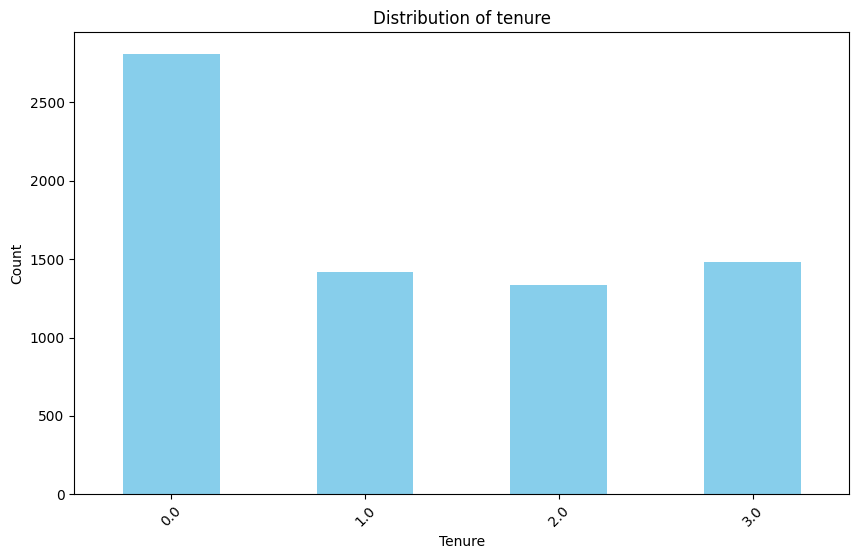

In [15]:
# Define tenure bins and labels
tenure_bins = [0, 20, 40, 60, 80, float('inf')]
tenure_labels = ['0 - 20', '20 - 40', '40 - 60', '60 - 80', '80+']

# Create a new column 'tenure_new' with bin labels
bucketizer = Bucketizer(splits=tenure_bins, inputCol="tenure", outputCol="tenure_new")
df = bucketizer.transform(df)

# Convert Spark DataFrame to Pandas DataFrame for plotting
df_pd = df.select('tenure_new').toPandas()

# Plotting the bar plot using matplotlib
plt.figure(figsize=(10, 6))
df_pd['tenure_new'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of tenure')
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Drop the 'tenure' column
df = df.drop("tenure")

In [17]:
# Display DataFrame schema
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- tenure_new: double (nullable = true)



In [18]:
# Count occurrences of each value in the 'PhoneService' column
phone_service_counts = df.groupBy("PhoneService").count().orderBy("count", ascending=False)
phone_service_counts.show()

+------------+-----+
|PhoneService|count|
+------------+-----+
|         Yes| 6361|
|          No|  682|
+------------+-----+



In [19]:
# Count occurrences of each value in the 'MultipleLines' column
multiple_lines_counts = df.groupBy("MultipleLines").count().orderBy("count", ascending=False)
multiple_lines_counts.show()

+----------------+-----+
|   MultipleLines|count|
+----------------+-----+
|              No| 3390|
|             Yes| 2971|
|No phone service|  682|
+----------------+-----+



In [20]:
# Count occurrences of each value in the 'InternetService' column
internet_service_counts = df.groupBy("InternetService").count().orderBy("count", ascending=False)
internet_service_counts.show()

+---------------+-----+
|InternetService|count|
+---------------+-----+
|    Fiber optic| 3096|
|            DSL| 2421|
|             No| 1526|
+---------------+-----+



In [21]:
# Count occurrences of each value in the 'OnlineSecurity' column
online_security_counts = df.groupBy("OnlineSecurity").count().orderBy("count", ascending=False)
online_security_counts.show()

+-------------------+-----+
|     OnlineSecurity|count|
+-------------------+-----+
|                 No| 3498|
|                Yes| 2019|
|No internet service| 1526|
+-------------------+-----+



In [22]:
# Count occurrences of each value in the 'OnlineBackup' column
online_backup_counts = df.groupBy("OnlineBackup").count().orderBy("count", ascending=False)
online_backup_counts.show()

+-------------------+-----+
|       OnlineBackup|count|
+-------------------+-----+
|                 No| 3088|
|                Yes| 2429|
|No internet service| 1526|
+-------------------+-----+



In [23]:
# Count occurrences of each value in the 'DeviceProtection' column
device_protection_counts = df.groupBy("DeviceProtection").count().orderBy("count", ascending=False)
device_protection_counts.show()

+-------------------+-----+
|   DeviceProtection|count|
+-------------------+-----+
|                 No| 3095|
|                Yes| 2422|
|No internet service| 1526|
+-------------------+-----+



In [24]:
# Count occurrences of each value in the 'TechSupport' column
tech_support_counts = df.groupBy("TechSupport").count().orderBy("count", ascending=False)
tech_support_counts.show()

+-------------------+-----+
|        TechSupport|count|
+-------------------+-----+
|                 No| 3473|
|                Yes| 2044|
|No internet service| 1526|
+-------------------+-----+



In [25]:
# Count occurrences of each value in the 'StreamingTV' column
streaming_tv_counts = df.groupBy("StreamingTV").count().orderBy("count", ascending=False)
streaming_tv_counts.show()

+-------------------+-----+
|        StreamingTV|count|
+-------------------+-----+
|                 No| 2810|
|                Yes| 2707|
|No internet service| 1526|
+-------------------+-----+



In [26]:
# Count occurrences of each value in the 'StreamingMovies' column
streaming_movies_counts = df.groupBy("StreamingMovies").count().orderBy("count", ascending=False)
streaming_movies_counts.show()

+-------------------+-----+
|    StreamingMovies|count|
+-------------------+-----+
|                 No| 2785|
|                Yes| 2732|
|No internet service| 1526|
+-------------------+-----+



In [27]:
# Count occurrences of each value in the 'Contract' column
contract_counts = df.groupBy("Contract").count().orderBy("count", ascending=False)
contract_counts.show()

+--------------+-----+
|      Contract|count|
+--------------+-----+
|Month-to-month| 3875|
|      Two year| 1695|
|      One year| 1473|
+--------------+-----+



In [28]:
# Count occurrences of each value in the 'PaperlessBilling' column
paperless_billing_counts = df.groupBy("PaperlessBilling").count().orderBy("count", ascending=False)
paperless_billing_counts.show()

+----------------+-----+
|PaperlessBilling|count|
+----------------+-----+
|             Yes| 4171|
|              No| 2872|
+----------------+-----+



In [29]:
# Count occurrences of each value in the 'PaymentMethod' column
payment_method_counts = df.groupBy("PaymentMethod").count().orderBy("count", ascending=False)
payment_method_counts.show()

+--------------------+-----+
|       PaymentMethod|count|
+--------------------+-----+
|    Electronic check| 2365|
|        Mailed check| 1612|
|Bank transfer (au...| 1544|
|Credit card (auto...| 1522|
+--------------------+-----+



In [30]:
# Count occurrences of each value in the 'MonthlyCharges' column
monthly_charges_counts = df.groupBy("MonthlyCharges").count().orderBy("count", ascending=False)
monthly_charges_counts.show()

+--------------+-----+
|MonthlyCharges|count|
+--------------+-----+
|         20.05|   61|
|         19.85|   45|
|         19.95|   44|
|          19.9|   44|
|         19.65|   43|
|          19.7|   43|
|          20.0|   43|
|         19.55|   40|
|         20.15|   40|
|         19.75|   39|
|         20.25|   39|
|          19.8|   38|
|         20.35|   38|
|          19.6|   37|
|          20.1|   37|
|          20.2|   35|
|          19.5|   32|
|         20.45|   31|
|          19.4|   31|
|          20.4|   30|
+--------------+-----+
only showing top 20 rows



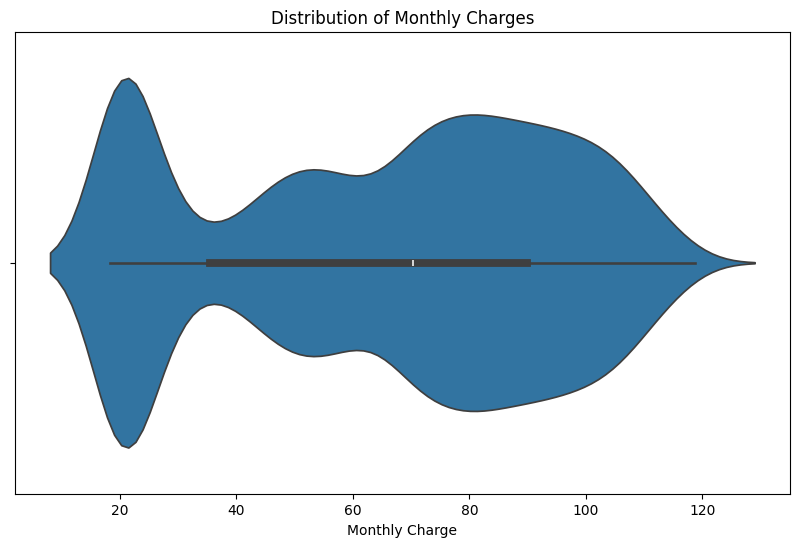

In [31]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
monthly_charges_pd_df = df.select('MonthlyCharges').toPandas()

# Plotting the violin plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=monthly_charges_pd_df, x='MonthlyCharges')
plt.xlabel('Monthly Charge')
plt.title('Distribution of Monthly Charges')
plt.show()

C:\Users\Sanjana Rayarala\AppData\Local\Temp\ipykernel_12852\3865238989.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pd, x='MonthlyCharges_new', order=monthly_labels, palette='viridis')


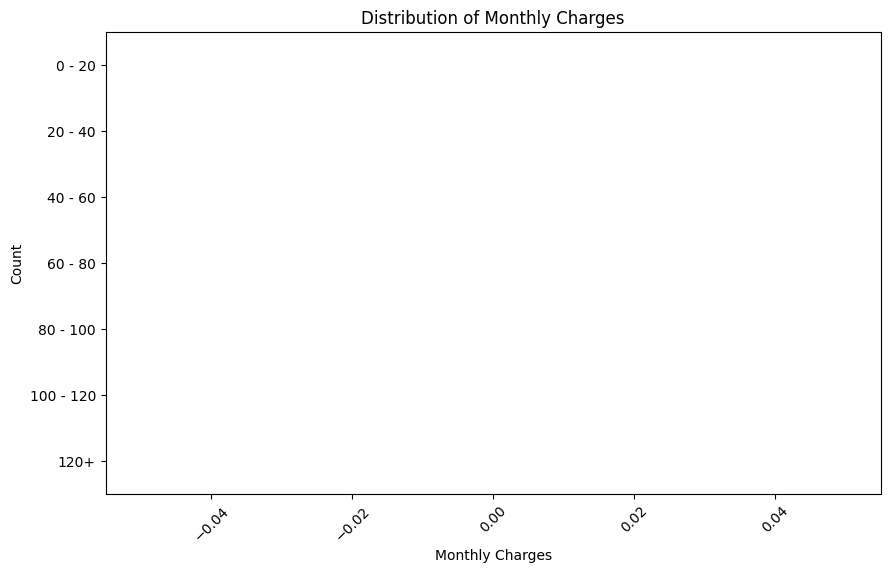

In [32]:
# Define bins and labels for monthly charges
monthly_bins = [0, 20, 40, 60, 80, 100, 120, float('inf')]
monthly_labels = ['0 - 20', '20 - 40', '40 - 60', '60 - 80', '80 - 100', '100 - 120', '120+']

# Create a new column 'MonthlyCharges_new' with bin labels
bucketizer = Bucketizer(splits=monthly_bins, inputCol="MonthlyCharges", outputCol="MonthlyCharges_new")
df = bucketizer.transform(df)

# Convert Spark DataFrame to Pandas DataFrame for plotting
df_pd = df.select('MonthlyCharges_new').toPandas()

# Plotting the violin plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_pd, x='MonthlyCharges_new', order=monthly_labels, palette='viridis')
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [33]:
# Drop the 'MonthlyCharges' column
df = df.drop("MonthlyCharges")

In [34]:
# Count occurrences of each value in the 'TotalCharges' column
total_charges_counts = df.groupBy("TotalCharges").count().orderBy("count", ascending=False)
total_charges_counts.show()

+------------+-----+
|TotalCharges|count|
+------------+-----+
|        20.2|   11|
|            |   11|
|       19.75|    9|
|        19.9|    8|
|       20.05|    8|
|       19.65|    8|
|       19.55|    7|
|        45.3|    7|
|       20.25|    6|
|       20.15|    6|
|       19.45|    6|
|        20.3|    5|
|       20.45|    5|
|        20.5|    4|
|        19.3|    4|
|        70.6|    4|
|        20.4|    4|
|        19.4|    4|
|        19.5|    4|
|        44.4|    4|
+------------+-----+
only showing top 20 rows



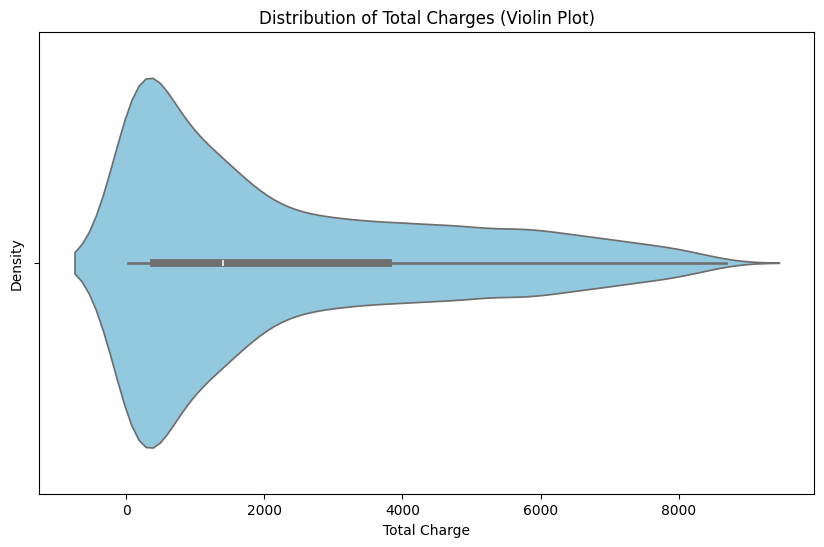

In [35]:
# Convert 'TotalCharges' column to numeric type
df = df.withColumn("TotalCharges", df["TotalCharges"].cast("float"))

# Convert Spark DataFrame to Pandas DataFrame for plotting
total_charges_pd_df = df.select('TotalCharges').toPandas()

# Plotting the violin plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(x=total_charges_pd_df['TotalCharges'], color='skyblue')
plt.xlabel('Total Charge')
plt.ylabel('Density')
plt.title('Distribution of Total Charges (Violin Plot)')
plt.show()

C:\Users\Sanjana Rayarala\AppData\Local\Temp\ipykernel_12852\2115690197.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=total_charges_pd_df, x='TotalCharges_new', order=total_labels, palette='viridis')


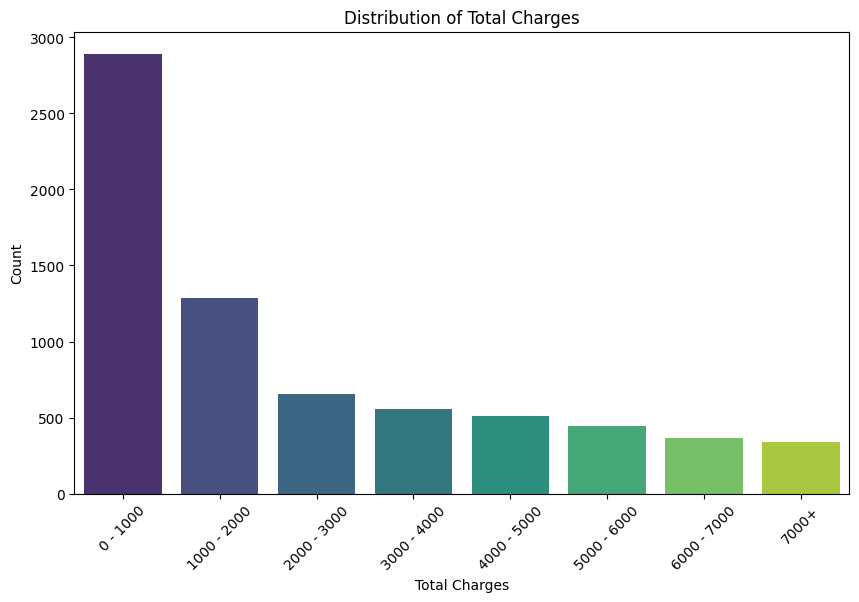

In [36]:
# Convert 'TotalCharges' column to numeric type
df = df.withColumn("TotalCharges", df["TotalCharges"].cast("float"))

# Define bins and labels for segmentation
total_bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, float('inf')]
total_labels = ['0 - 1000', '1000 - 2000', '2000 - 3000', '3000 - 4000', '4000 - 5000', '5000 - 6000', '6000 - 7000', '7000+']

# Create a new column with segmented categories
df = df.withColumn("TotalCharges_new", 
                   when((col("TotalCharges") >= 0) & (col("TotalCharges") < 1000), "0 - 1000")
                   .when((col("TotalCharges") >= 1000) & (col("TotalCharges") < 2000), "1000 - 2000")
                   .when((col("TotalCharges") >= 2000) & (col("TotalCharges") < 3000), "2000 - 3000")
                   .when((col("TotalCharges") >= 3000) & (col("TotalCharges") < 4000), "3000 - 4000")
                   .when((col("TotalCharges") >= 4000) & (col("TotalCharges") < 5000), "4000 - 5000")
                   .when((col("TotalCharges") >= 5000) & (col("TotalCharges") < 6000), "5000 - 6000")
                   .when((col("TotalCharges") >= 6000) & (col("TotalCharges") < 7000), "6000 - 7000")
                   .otherwise("7000+"))

# Convert Spark DataFrame to Pandas DataFrame for plotting
total_charges_pd_df = df.select('TotalCharges_new').toPandas()

# Plotting the count of each category
plt.figure(figsize=(10, 6))
sns.countplot(data=total_charges_pd_df, x='TotalCharges_new', order=total_labels, palette='viridis')
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [37]:
# Dropping the "TotalCharges" column
df = df.drop("TotalCharges")

In [38]:
# Checking value counts of the "Churn" column
churn_counts = df.groupBy("Churn").count()
churn_counts.show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



In [39]:
# Splitting the DataFrame into features (X) and target variable (y)
features = df.drop("Churn")
target = df.select("Churn")

In [40]:
# Printing information about the DataFrame
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- tenure_new: double (nullable = true)
 |-- MonthlyCharges_new: double (nullable = true)
 |-- TotalCharges_new: string (nullable = false)



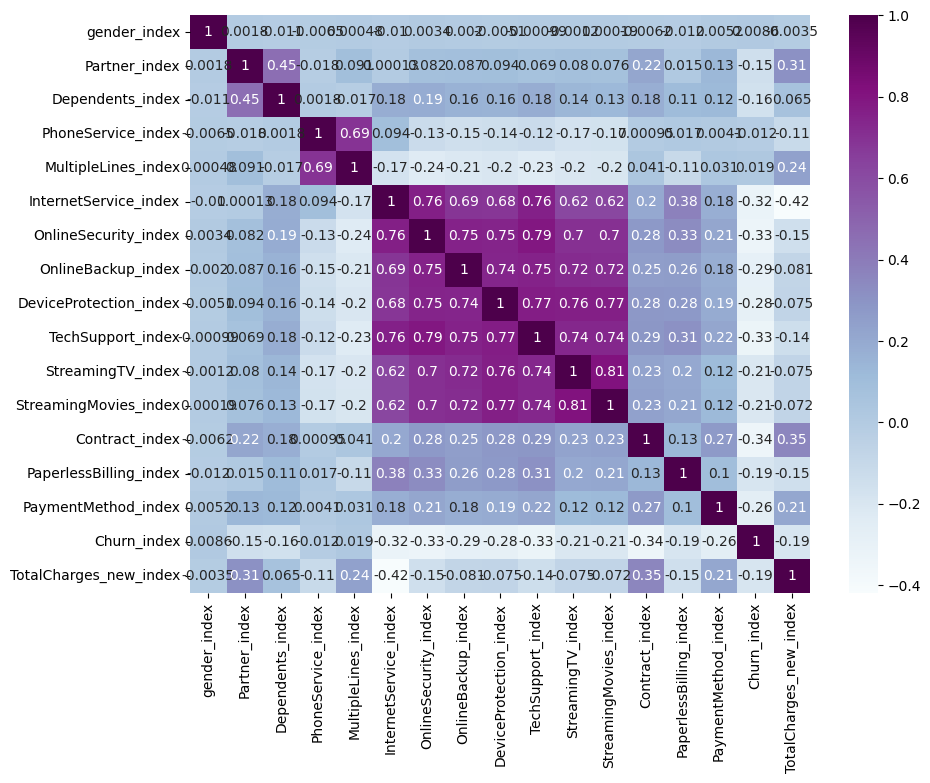

In [41]:
# Define a list of string columns
string_cols = [col_name for col_name, data_type in df.dtypes if data_type == 'string']

# Use StringIndexer to convert string columns into numerical categories
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in string_cols]
indexer_pipeline = Pipeline(stages=indexers)
indexed_df = indexer_pipeline.fit(df).transform(df)

# Select only the indexed columns
indexed_cols = [col_name + "_index" for col_name in string_cols]
features = indexed_df.select(indexed_cols)

# Combine features into a single vector column
vector_assembler = VectorAssembler(inputCols=features.columns, outputCol="features")
vectorized_df = vector_assembler.transform(indexed_df).select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(vectorized_df, "features").collect()[0][0]

# Convert the correlation matrix to a Pandas DataFrame for visualization
corr_matrix_pd = correlation_matrix.toArray().tolist()
corr_df = pd.DataFrame(corr_matrix_pd, columns=features.columns, index=features.columns)

# Plot the heatmap
plt.figure(figsize=(10, 7.5))
sns.heatmap(corr_df, annot=True, cmap='BuPu')
plt.show()


In [42]:
# Print schema of the encoded DataFrame
indexed_df.printSchema()

# Alternatively, you can use describe() to get summary statistics
indexed_df.describe().show()


root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- tenure_new: double (nullable = true)
 |-- MonthlyCharges_new: double (nullable = true)
 |-- TotalCharges_new: string (nullable = false)
 |-- gender_index: double (nullable = false)
 |-- Partner_index: double (nullable = false)
 |-- Dependents_index

In [43]:
'''
# Separate features and target variable
x = df.drop("Churn")  # Assuming 'Churn' is the target variable
y = df.select("Churn")

# Split the data into training and testing sets
train_ratio = 0.8
test_ratio = 0.2
seed = 42  # for reproducibility

# Randomly split the data
x_train, x_test = x.randomSplit([train_ratio, test_ratio], seed=seed)
y_train, y_test = y.randomSplit([train_ratio, test_ratio], seed=seed)

# Show the number of records in each set
print("Number of records in training set (x_train):", x_train.count())
print("Number of records in testing set (x_test):", x_test.count())
print("Number of records in training set (y_train):", y_train.count())
print("Number of records in testing set (y_test):", y_test.count())
'''

'\n# Separate features and target variable\nx = df.drop("Churn")  # Assuming \'Churn\' is the target variable\ny = df.select("Churn")\n\n# Split the data into training and testing sets\ntrain_ratio = 0.8\ntest_ratio = 0.2\nseed = 42  # for reproducibility\n\n# Randomly split the data\nx_train, x_test = x.randomSplit([train_ratio, test_ratio], seed=seed)\ny_train, y_test = y.randomSplit([train_ratio, test_ratio], seed=seed)\n\n# Show the number of records in each set\nprint("Number of records in training set (x_train):", x_train.count())\nprint("Number of records in testing set (x_test):", x_test.count())\nprint("Number of records in training set (y_train):", y_train.count())\nprint("Number of records in testing set (y_test):", y_test.count())\n'

In [44]:
'''# Assuming 'y' is a DataFrame containing the target variable
# Group by the target variable and count the occurrences of each value
y_counts = y.groupBy("Churn").count()

# Show the counts
y_counts.show()'''

'# Assuming \'y\' is a DataFrame containing the target variable\n# Group by the target variable and count the occurrences of each value\ny_counts = y.groupBy("Churn").count()\n\n# Show the counts\ny_counts.show()'

# Model Development

In [45]:
#Import H2O and initialize
import h2o
h2o.init()

# Importing data into H2O Frame
pd_df= df.toPandas()
hf = h2o.H2OFrame(pd_df)

#Specify target and features
target = 'Churn'
features = hf.columns
features.remove(target)

#Splitting data into train and test sets
train, test = hf.split_frame(ratios=[.8], seed=42)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Microsoft-25199 (build 11.0.12+7, mixed mode).12" 2021-07-20
  Starting server from C:\Users\Sanjana Rayarala\AppData\Local\Programs\Python\Python310\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\SANJAN~1\AppData\Local\Temp\tmpe1wi81ct
  JVM stdout: C:\Users\SANJAN~1\AppData\Local\Temp\tmpe1wi81ct\h2o_Sanjana_Rayarala_started_from_python.out
  JVM stderr: C:\Users\SANJAN~1\AppData\Local\Temp\tmpe1wi81ct\h2o_Sanjana_Rayarala_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,H2O_from_python_Sanjana_Rayarala_g4ow68
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,512 Mb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [46]:
from h2o.estimators import H2ORandomForestEstimator, H2OGradientBoostingEstimator, H2ODeepLearningEstimator

#train Random Forest Model
rf_model = H2ORandomForestEstimator()
rf_model.train(x=features, y=target, training_frame=train)

#train GBM Model
gbm_model = H2OGradientBoostingEstimator()
gbm_model.train(x=features, y=target, training_frame=train)

#train Deep Learning Model
dl_model = H2ODeepLearningEstimator(hidden=[10, 10], epochs=50)
dl_model.train(x=features, y=target, training_frame=train)

# Evaluate model performance
performance_rf = rf_model.model_performance(test_data=test)
performance_gbm = gbm_model.model_performance(test_data=test)
performance_dl = dl_model.model_performance(test_data=test)

print('Random Forest Performance:', performance_rf.auc())
print('GBM Performance:', performance_gbm.auc())
print('Deep Learning Performance:', performance_dl.auc())


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Random Forest Performance: 0.7957824445897983
GBM Performance: 0.8132579697401859
Deep Learning Performance: 0.8023743016759776


In [47]:
# Print accuracy, precision, recall, and F1-score for Random Forest model
print('Random Forest Accuracy:', performance_rf.accuracy()[0][1])
print('Random Forest Precision:', performance_rf.precision()[0][1])
print('Random Forest Recall:', performance_rf.recall()[0][1])
print('Random Forest F1 Score:', performance_rf.F1()[0][1])

# Print accuracy, precision, recall, and F1-score for GBM model
print('GBM Accuracy:', performance_gbm.accuracy()[0][1])
print('GBM Precision:', performance_gbm.precision()[0][1])
print('GBM Recall:', performance_gbm.recall()[0][1])
print('GBM F1 Score:', performance_gbm.F1()[0][1])

# Print accuracy, precision, recall, and F1-score for Deep Learning model
print('Deep Learning Accuracy:', performance_dl.accuracy()[0][1])
print('Deep Learning Precision:', performance_dl.precision()[0][1])
print('Deep Learning Recall:', performance_dl.recall()[0][1])
print('Deep Learning F1 Score:', performance_dl.F1()[0][1])

Random Forest Accuracy: 0.7928571428571428
Random Forest Precision: 1.0
Random Forest Recall: 1.0
Random Forest F1 Score: 0.5672575599582899
GBM Accuracy: 0.7971428571428572
GBM Precision: 1.0
GBM Recall: 1.0
GBM F1 Score: 0.5868263473053892
Deep Learning Accuracy: 0.7907142857142857
Deep Learning Precision: 1.0
Deep Learning Recall: 1.0
Deep Learning F1 Score: 0.5799522673031027


In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

pd_df=df.toPandas()
pd_df['Churn'] = pd_df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0).astype('float32')

pd_df = pd.get_dummies(pd_df, drop_first=True)  # One-hot encode all categorical variables

#Define features and target
features = pd_df.drop('Churn', axis=1).columns.tolist()
target = 'Churn'

#Split the data
X = pd_df[features].astype('float32')  # Ensure all input features are float
y = pd_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Convert to TensorFlow dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values)).shuffle(buffer_size=len(X_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(32)

#TensorFlow model with dropout and L2 regularization
model = Sequential([
    Dense(128, kernel_regularizer=l2(0.01), activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

#Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

#early stopping
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Train the model 
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=test_ds,
    callbacks=[early_stopping_monitor]
)

# Evaluating the model
loss, accuracy, auc_score = model.evaluate(test_ds)
print(f'Neural Network Accuracy: {accuracy}')
print(f'Neural Network AUC: {auc_score}')

Epoch 1/100


c:\Users\Sanjana Rayarala\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6762 - auc: 0.6478 - loss: 1.1143 - val_accuracy: 0.8155 - val_auc: 0.8540 - val_loss: 0.6302
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7792 - auc: 0.8167 - loss: 0.6312 - val_accuracy: 0.8133 - val_auc: 0.8567 - val_loss: 0.5318
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7829 - auc: 0.8164 - loss: 0.5537 - val_accuracy: 0.7991 - val_auc: 0.8565 - val_loss: 0.4960
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7885 - auc: 0.8142 - loss: 0.5365 - val_accuracy: 0.8141 - val_auc: 0.8571 - val_loss: 0.4735
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7908 - auc: 0.8186 - loss: 0.5081 - val_accuracy: 0.8048 - val_auc: 0.8569 - val_loss: 0.4640
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7848 - auc: 0.8173 - loss: 0.5063 - val_accuracy: 0.8105 - val_auc: 0.8549 - val_loss: 0.4593
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

In [84]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_test and model predictions are available
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:
 [[946  90]
 [160 213]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.91      0.88      1036
         1.0       0.70      0.57      0.63       373

    accuracy                           0.82      1409
   macro avg       0.78      0.74      0.76      1409
weighted avg       0.81      0.82      0.82      1409



c:\Users\Sanjana Rayarala\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Sanjana Rayarala\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Sanjana Rayarala\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Sanjana Rayarala\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_s

In [53]:
print(X_train.columns)

Index(['SeniorCitizen', 'tenure_new', 'MonthlyCharges_new', 'gender_Male',
       'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'TotalCharges_new_1000 - 2000', 'TotalCharges_new_2000 - 3000',
       'TotalCharges_new_3000 - 4000', 'TotalCharges_new_4000 - 5000',
       'TotalChar

In [56]:
X_train.head()

,SeniorCitizen,tenure_new,MonthlyCharges_new,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges_new_1000 - 2000,TotalCharges_new_2000 - 3000,TotalCharges_new_3000 - 4000,TotalCharges_new_4000 - 5000,TotalCharges_new_5000 - 6000,TotalCharges_new_6000 - 7000,TotalCharges_new_7000+
2142,0.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1623,0.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6074,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1362,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6754,0.0,0.0,3.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [59]:
sample_input = {
    'SeniorCitizen': [0],
    'tenure_new': [2],  
    'MonthlyCharges_new': [4],  
    'gender_Male': [1],
    'Partner_Yes': [0],
    'Dependents_Yes': [0],
    'PhoneService_Yes': [1],
    'MultipleLines_No phone service': [0],
    'MultipleLines_Yes': [0],
    'InternetService_Fiber optic': [0],
    'InternetService_No': [0],
    'OnlineSecurity_No internet service': [0],
    'OnlineSecurity_Yes': [0],
    'OnlineBackup_No internet service': [0],
    'OnlineBackup_Yes': [0],
    'DeviceProtection_No internet service': [0],
    'DeviceProtection_Yes': [0],
    'TechSupport_No internet service': [0],
    'TechSupport_Yes': [0],
    'StreamingTV_No internet service': [0],
    'StreamingTV_Yes': [0],
    'StreamingMovies_No internet service': [0],
    'StreamingMovies_Yes': [0],
    'Contract_One year': [0],
    'Contract_Two year': [0],
    'PaperlessBilling_Yes': [1],
    'PaymentMethod_Credit card (automatic)': [0],
    'PaymentMethod_Electronic check': [1],
    'PaymentMethod_Mailed check': [0],
    'TotalCharges_new_1000 - 2000': [0],
    'TotalCharges_new_2000 - 3000': [0],
    'TotalCharges_new_3000 - 4000': [0],
    'TotalCharges_new_4000 - 5000': [0],
    'TotalCharges_new_5000 - 6000': [1],
    'TotalCharges_new_6000 - 7000': [0],
    'TotalCharges_new_7000+': [0]
}


In [89]:
sample_input_df = pd.DataFrame(sample_input)

sample_tf_dataset = tf.data.Dataset.from_tensor_slices((sample_input_df.values)).batch(1)

predictions = model.predict(sample_tf_dataset)

# Convert probability to class label
threshold = 0.5
class_predictions = (predictions > threshold).astype(int)

# Map numeric class to string labels
class_labels = ['No', 'Yes']
mapped_predictions = [class_labels[pred] for pred in class_predictions.flatten()]

print("Predicted class probabilities:", predictions)
print("Predicted class 'Churn' labels:", mapped_predictions)

print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Predicted class probabilities: [[0.2916243]]
Predicted class 'Churn' labels: ['No']
[[0.2916243]]


In [90]:
sample_input2 = {
    'SeniorCitizen': [1],  # Senior citizens might have different service needs or preferences.
    'tenure_new': [0],  # Shorter tenure might indicate a higher likelihood of churn.
    'MonthlyCharges_new': [5],  # Higher monthly charges might correlate with churn.
    'gender_Male': [0],
    'Partner_Yes': [0],
    'Dependents_Yes': [0],
    'PhoneService_Yes': [1],
    'MultipleLines_No phone service': [0],
    'MultipleLines_Yes': [1],  # Having multiple lines might be a minor factor.
    'InternetService_Fiber optic': [1],  # Customers with fiber optic might have higher expectations and churn if not met.
    'InternetService_No': [0],
    'OnlineSecurity_No internet service': [0],
    'OnlineSecurity_Yes': [0],
    'OnlineBackup_No internet service': [0],
    'OnlineBackup_Yes': [1],  # Using more services could correlate with churn if the services don't meet expectations.
    'DeviceProtection_No internet service': [0],
    'DeviceProtection_Yes': [1],
    'TechSupport_No internet service': [0],
    'TechSupport_Yes': [0],
    'StreamingTV_No internet service': [0],
    'StreamingTV_Yes': [1],
    'StreamingMovies_No internet service': [0],
    'StreamingMovies_Yes': [1],
    'Contract_One year': [0],
    'Contract_Two year': [0],  # Shorter contract terms might correlate with higher churn.
    'PaperlessBilling_Yes': [1],
    'PaymentMethod_Credit card (automatic)': [0],
    'PaymentMethod_Electronic check': [1],  # Electronic checks might have a higher churn due to the demographics using them.
    'PaymentMethod_Mailed check': [0],
    'TotalCharges_new_1000 - 2000': [0],
    'TotalCharges_new_2000 - 3000': [0],
    'TotalCharges_new_3000 - 4000': [0],
    'TotalCharges_new_4000 - 5000': [0],
    'TotalCharges_new_5000 - 6000': [0],
    'TotalCharges_new_6000 - 7000': [0],
    'TotalCharges_new_7000+': [1]  # High total charges might also influence churn.
}

sample_input_df2 = pd.DataFrame(sample_input2)

sample_tf_dataset2 = tf.data.Dataset.from_tensor_slices((sample_input_df2.values)).batch(1)

predictions = model.predict(sample_tf_dataset2)

threshold = 0.5
class_predictions = (predictions > threshold).astype(int)

class_labels = ['No', 'Yes']
mapped_predictions = [class_labels[pred] for pred in class_predictions.flatten()]

print("Predicted class probabilities:", predictions)
print("Predicted class 'Churn' labels:", mapped_predictions)

print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class probabilities: [[0.7264483]]
Predicted class 'Churn' labels: ['Yes']
[[0.7264483]]


In [94]:
model.save('model.h5')

In [98]:
print(tf.__version__)

2.16.1


In [99]:
import json

# Convert the dictionary to a JSON string
json_data = json.dumps(sample_input2)

# Save this JSON data to a file
with open('data.json', 'w') as file:
    file.write(json_data)

In [103]:
import tarfile
import os

# Define the name of the tar.gz archive
tar_filename = "model.tar.gz"

# Files to include in the tar.gz archive
files_to_archive = ["model.h5"]

# Create a tar.gz archive
with tarfile.open(tar_filename, "w:gz") as tar:
    # Add each file to the archive
    for file in files_to_archive:
        tar.add(file)

# Optionally, delete the original files
for file in files_to_archive:
    os.remove(file)